## Code for the experiments - training with Adam and no dropout
### Importing and preparing data
First we import the relevant packages. 

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import to_categorical

Using TensorFlow backend.


Importing the dataset MNIST_fashion. It is an MNIST-like dataset, but contains images of clothing instead of numbers. The image size is the same as in MNIST. 

In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [3]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Scaling the pixels to values between 0 and 1. 

In [4]:
train_images = train_images / 255.0
test_images = test_images / 255.0

The labels are given in integer values between 0 and 9. For the Self-Distillation we convert these into the one-hot representation, for example a trouser with label [1] now has label [0,1,0,0,0,0,0,0,0,0] with 1 at the first entry (note that counting starts with 0 here). 

In [5]:
train_labels_onehot = to_categorical(train_labels)
test_labels_onehot = to_categorical(test_labels)

Reshaping the data so that it fits into the functions later. 

In [6]:
im_rows=28
im_cols=28
im_shape=(im_rows,im_cols,1)

train_images = train_images.reshape(train_images.shape[0],*im_shape)
test_images = test_images.reshape(test_images.shape[0],*im_shape)

### Defining the models
Defining all the models that will be used later, so that we can see a summary. Note that the each model will be re-initialized later in each for-step, since each Self-Distillation step requires a fresh model that hasn't been trained yet. 

In [8]:
name = 'Convolutional_2_Layer'
cnn_model_2 = keras.Sequential([
    keras.layers.Conv2D(filters=32,kernel_size=3,input_shape=im_shape),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Conv2D(filters = 64, kernel_size = 3, activation ='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(10, activation ='softmax')], name = name)

name = 'Convolutional_4_Layer_CE'
cnn_model_4 = keras.Sequential([
    keras.layers.Conv2D(filters=32,kernel_size=3,input_shape=im_shape),
    keras.layers.Conv2D(filters=32,kernel_size=3,input_shape=im_shape),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Conv2D(filters = 64, kernel_size = 3, activation ='relu'),
    keras.layers.Conv2D(filters = 128, kernel_size =3, activation ='relu'),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(128,activation='relu'),
    keras.layers.Dense(10)], name = name)

name = 'Feedforward_2_Layer'
ff_model_2 = keras.Sequential([
    keras.layers.Flatten(input_shape=im_shape),
    keras.layers.Dense(128,activation='relu'),
    keras.layers.Dense(128,activation='relu'),
    keras.layers.Dense(10, activation ='softmax')], name = name)


models = [cnn_model_2, cnn_model_4, ff_model_2]

In [9]:
for model in models:
    model.summary()

Model: "Convolutional_2_Layer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
dropout_9 (Dropout)          (None, 11, 11, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 7744)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)      

### Training the CNN's with cross-entropy loss
##### Training the 2-layer CNN with cross-entropy loss

In [ ]:
train_labels_Iterations_2layerCE = np.zeros((60000,10,8),dtype='float32')
label_update_2layerCE = train_labels_onehot
predictions_2layerCE = np.zeros((10000,10,8),dtype='float32')
test_loss_2CNNCE = np.zeros(8,dtype='float32')
test_acc_2CNNCE = np.zeros(8,dtype='float32')
for i in range(8):
    print('ROUND',i+1)
    
    name = 'Convolutional_2_Layer_CE'
    cnn_model_2CE = keras.Sequential([
    keras.layers.Conv2D(filters=32,kernel_size=3,input_shape=im_shape),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Conv2D(filters = 64, kernel_size = 3, activation ='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(10)], name = name)
    
    cnn_model_2CE.compile(optimizer='Adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    
    cnn_model_2CE.fit(train_images, label_update_2layerCE, epochs=10)
    probability_cnn_model_2CE = tf.keras.Sequential([cnn_model_2CE, 
                                         tf.keras.layers.Softmax()])
    test_loss_2CNNCE[i], test_acc_2CNNCE[i] = cnn_model_2CE.evaluate(test_images,  test_labels_onehot, verbose=2)
    print('\nTest accuracy:', test_acc_2CNNCE[i])
    label_update_2layerCE = probability_cnn_model_2CE.predict(train_images)
    predictions_2layerCE[:,:,i] = probability_cnn_model_2CE.predict(test_images)

##### Training the 4layer convoluiontal NN with cross-entropy loss

In [ ]:
train_labels_Iterations_4layerCE = np.zeros((60000,10,8),dtype='float32')
label_update_4layerCE = train_labels_onehot
predictions_4layerCE = np.zeros((10000,10,8),dtype='float32')
test_loss_4CNNCE = np.zeros(8,dtype='float32')
test_acc_4CNNCE = np.zeros(8,dtype='float32')
for i in range(8):
    print('ROUND',i+1)
    
    name = 'Convolutional_4_Layer_CE'
    cnn_model_4CE = keras.Sequential([
    keras.layers.Conv2D(filters=32,kernel_size=3,input_shape=im_shape),
    keras.layers.Conv2D(filters=32,kernel_size=3,input_shape=im_shape),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Conv2D(filters = 64, kernel_size = 3, activation ='relu'),
    keras.layers.Conv2D(filters = 128, kernel_size =3, activation ='relu'),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(128,activation='relu'),
    keras.layers.Dense(10)], name = name)
    
    cnn_model_4CE.compile(optimizer='Adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    
    cnn_model_4CE.fit(train_images, label_update_4layerCE, epochs=10)
    probability_cnn_model_4CE = tf.keras.Sequential([cnn_model_4CE, 
                                         tf.keras.layers.Softmax()])
    test_loss_4CNNCE[i], test_acc_4CNNCE[i] = cnn_model_4CE.evaluate(test_images,  test_labels_onehot, verbose=2)
    print('\nTest accuracy:', test_acc_4CNNCE[i])
    label_update_4layerCE = probability_cnn_model_4CE.predict(train_images)
    predictions_4layerCE[:,:,i] = probability_cnn_model_4CE.predict(test_images)

### Training the CNN's with mean-squared-error loss
##### Training the 2-layer CNN mean-squared-error loss

In [ ]:
train_labels_Iterations_2layerMSE = np.zeros((60000,10,8),dtype='float32')
label_update_2layerMSE = train_labels_onehot
predictions_2layerMSE = np.zeros((10000,10,8),dtype='float32')
test_loss_2CNNMSE = np.zeros(8,dtype='float32')
test_acc_2CNNMSE = np.zeros(8,dtype='float32')
for i in range(8):
    print('ROUND',i+1)
    
    name = 'Convolutional_2_Layer_MSE'
    cnn_model_2MSE = keras.Sequential([
    keras.layers.Conv2D(filters=32,kernel_size=3,input_shape=im_shape),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Conv2D(filters = 64, kernel_size = 3, activation ='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(10)], name = name)
    
    cnn_model_2MSE.compile(optimizer='Adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy'])
    
    cnn_model_2MSE.fit(train_images, label_update_2layerMSE, epochs=10)
    probability_cnn_model_2MSE = tf.keras.Sequential([cnn_model_2MSE, 
                                         tf.keras.layers.Softmax()])
    test_loss_2CNNMSE[i], test_acc_2CNNMSE[i] = cnn_model_2MSE.evaluate(test_images,  test_labels_onehot, verbose=2)
    print('\nTest accuracy:', test_acc_2CNNMSE[i])
    label_update_2layerMSE = probability_cnn_model_2MSE.predict(train_images)
    predictions_2layerMSE[:,:,i] = probability_cnn_model_2MSE.predict(test_images)

##### Training the 4layer convoluiontal NN with mean-squared-error loss

In [ ]:
train_labels_Iterations_4layerMSE = np.zeros((60000,10,8),dtype='float32')
label_update_4layerMSE = train_labels_onehot
predictions_4layerMSE = np.zeros((10000,10,8),dtype='float32')
test_loss_4CNNMSE = np.zeros(8,dtype='float32')
test_acc_4CNNMSE = np.zeros(8,dtype='float32')
for i in range(18):
    print('ROUND',i+1)
    
    name = 'Convolutional_4_Layer_MSE'
    cnn_model_4MSE = keras.Sequential([
    keras.layers.Conv2D(filters=32,kernel_size=3,input_shape=im_shape),
    keras.layers.Conv2D(filters=32,kernel_size=3,input_shape=im_shape),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Conv2D(filters = 64, kernel_size = 3, activation ='relu'),
    keras.layers.Conv2D(filters = 128, kernel_size =3, activation ='relu'),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(128,activation='relu'),
    keras.layers.Dense(10)], name = name)
    
    cnn_model_4MSE.compile(optimizer='Adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy'])
    
    cnn_model_4MSE.fit(train_images, label_update_4layerMSE, epochs=10)
    probability_cnn_model_4MSE = tf.keras.Sequential([cnn_model_4MSE, 
                                         tf.keras.layers.Softmax()])
    test_loss_4CNNMSE[i], test_acc_4CNNMSE[i] = cnn_model_4MSE.evaluate(test_images,  test_labels_onehot, verbose=2)
    print('\nTest accuracy:', test_acc_4CNNMSE[i])
    label_update_4layerMSE = probability_cnn_model_4MSE.predict(train_images)
    predictions_4layerMSE[:,:,i] = probability_cnn_model_4MSE.predict(test_images)

### Training the feed-forward NN with cross-entropy loss and mean-squared-error loss
###### Training the 2-layer feed-forward NN with cross-entropy loss

In [13]:
train_labels_Iterations_2layerFF_CE = np.zeros((60000,10,8),dtype='float32')
label_update_2layerFF_CE = train_labels_onehot
predictions_2layerFF_CE = np.zeros((10000,10,8),dtype='float32')
test_loss_2FFCE = np.zeros(8,dtype='float32')
test_acc_2FFCE = np.zeros(8,dtype='float32')
for i in range(8):
    print('ROUND',i+1)
    
    name = 'Feedforward_2_Layer_CE'
    ff_model_2CE = keras.Sequential([
    keras.layers.Flatten(input_shape=im_shape),
    keras.layers.Dense(128,activation='relu'),
    keras.layers.Dense(128,activation='relu'),
    keras.layers.Dense(10, activation ='softmax')], name = name)
    
    ff_model_2CE.compile(optimizer='Adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    
    ff_model_2CE.fit(train_images, label_update_2layerFF_CE, epochs=10)
    probability_ff_model_2CE = tf.keras.Sequential([ff_model_2CE, 
                                         tf.keras.layers.Softmax()])
    test_loss_2FFCE[i], test_acc_2FFCE[i] = ff_model_2CE.evaluate(test_images,  test_labels_onehot, verbose=2)
    print('\nTest accuracy:', test_acc_2FFCE[i])
    label_update_2layerFF_CE = probability_ff_model_2CE.predict(train_images)
    predictions_2layerFF_CE[:,:,i] = probability_ff_model_2CE.predict(test_images)

ROUND 1
Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 4s 74us/sample - loss: 2.0718 - accuracy: 0.4247
Epoch 2/10
60000/60000 [==============================] - 4s 68us/sample - loss: 1.8619 - accuracy: 0.6224
Epoch 3/10
60000/60000 [==============================] - 4s 68us/sample - loss: 1.7797 - accuracy: 0.7139
Epoch 4/10
60000/60000 [==============================] - 4s 68us/sample - loss: 1.7432 - accuracy: 0.7413
Epoch 5/10
60000/60000 [==============================] - 4s 68us/sample - loss: 1.7255 - accuracy: 0.7533
Epoch 6/10
60000/60000 [==============================] - 4s 67us/sample - loss: 1.7142 - accuracy: 0.7603
Epoch 7/10
60000/60000 [==============================] - 4s 67us/sample - loss: 1.7058 - accuracy: 0.7673
Epoch 8/10
60000/60000 [==============================] - 4s 67us/sample - loss: 1.7003 - accuracy: 0.7709
Epoch 9/10
60000/60000 [==============================] - 4s 67us/sample - loss: 1.6952 - accuracy: 0.7751
Epoch 


Test accuracy: 0.6098
ROUND 8
Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 5s 77us/sample - loss: 2.3010 - accuracy: 0.2901
Epoch 2/10
60000/60000 [==============================] - 4s 68us/sample - loss: 2.2964 - accuracy: 0.4954
Epoch 3/10
60000/60000 [==============================] - 4s 68us/sample - loss: 2.2901 - accuracy: 0.6557
Epoch 4/10
60000/60000 [==============================] - 4s 68us/sample - loss: 2.2834 - accuracy: 0.7917
Epoch 5/10
60000/60000 [==============================] - 4s 69us/sample - loss: 2.2797 - accuracy: 0.8666
Epoch 6/10
60000/60000 [==============================] - 4s 68us/sample - loss: 2.2781 - accuracy: 0.8894
Epoch 7/10
60000/60000 [==============================] - 4s 69us/sample - loss: 2.2774 - accuracy: 0.9001
Epoch 8/10
60000/60000 [==============================] - 4s 68us/sample - loss: 2.2770 - accuracy: 0.9075
Epoch 9/10
60000/60000 [==============================] - 4s 68us/sample - loss: 2.2768 - 

###### Training the 2-layer feed-forward NN with mean-squared-error loss

In [ ]:
train_labels_Iterations_2layerFF_MSE = np.zeros((60000,10,8),dtype='float32')
label_update_2layerFF_MSE = train_labels_onehot
predictions_2layerFF_MSE = np.zeros((10000,10,8),dtype='float32')
test_loss_2FFMSE = np.zeros(8,dtype='float32')
test_acc_2FFMSE = np.zeros(8,dtype='float32')
for i in range(8):
    print('ROUND',i+1)
    
    name = 'Feedforward_2_Layer_MSE'
    ff_model_2MSE = keras.Sequential([
    keras.layers.Flatten(input_shape=im_shape),
    keras.layers.Dense(128,activation='relu'),
    keras.layers.Dense(128,activation='relu'),
    keras.layers.Dense(10, activation ='softmax')], name = name)
    
    ff_model_2MSE.compile(optimizer='Adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy'])
    
    ff_model_2MSE.fit(train_images, label_update_2layerFF_MSE, epochs=10)
    probability_ff_model_2MSE = tf.keras.Sequential([ff_model_2MSE, 
                                         tf.keras.layers.Softmax()])
    test_loss_2FFMSE[i], test_acc_2FFMSE[i] = ff_model_2MSE.evaluate(test_images,  test_labels_onehot, verbose=2)
    print('\nTest accuracy:', test_acc_2FFMSE[i])
    label_update_2layerFF_MSE = probability_ff_model_2MSE.predict(train_images)
    predictions_2layerFF_MSE[:,:,i] = probability_ff_model_2MSE.predict(test_images)

ROUND 1
Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 4s 69us/sample - loss: 0.0860 - accuracy: 0.2855
Epoch 2/10
60000/60000 [==============================] - 4s 62us/sample - loss: 0.0723 - accuracy: 0.5178
Epoch 3/10
60000/60000 [==============================] - 4s 62us/sample - loss: 0.0577 - accuracy: 0.6094
Epoch 4/10
60000/60000 [==============================] - 4s 62us/sample - loss: 0.0493 - accuracy: 0.6521
Epoch 5/10
60000/60000 [==============================] - 4s 62us/sample - loss: 0.0449 - accuracy: 0.6781
Epoch 6/10
60000/60000 [==============================] - 4s 61us/sample - loss: 0.0421 - accuracy: 0.7042
Epoch 7/10
60000/60000 [==============================] - 4s 61us/sample - loss: 0.0398 - accuracy: 0.7301
Epoch 8/10
60000/60000 [==============================] - 4s 61us/sample - loss: 0.0379 - accuracy: 0.7512
Epoch 9/10
60000/60000 [==============================] - 4s 61us/sample - loss: 0.0362 - accuracy: 0.7651
Epoch 

NameError: name 'test_acc_2layerFF_MSE' is not defined

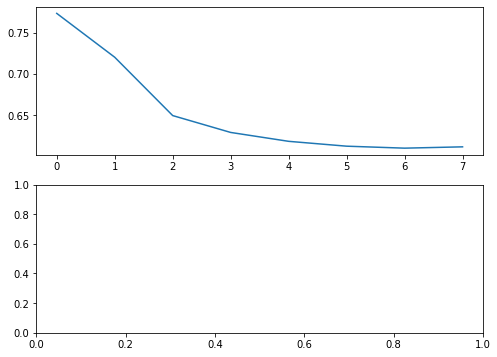

In [27]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(8, 6))

ax1.plot(test_acc_2CNNCE,label='2 Layer CNN, CE')
ax1.plot(test_acc_2CNNMSE,label='2 Layer CNN, MSE')
ax1.plot(test_acc_4CNNCE,label='4 Layer CNN, CE')
ax1.plot(test_acc_4CNNMSE,label='4 Layer CNN, CE')
ax1.plot(test_acc_2FFCE,label='2 Layer FF, CE')
ax1.plot(test_acc_2FFMSE,label='2 Layer FF, MSE')

ax2.plot(test_loss_2CNNCE,label='2 Layer CNN, CE')
ax2.plot(test_loss_2CNNMSE,label='2 Layer CNN, MSE')
ax2.plot(test_loss_4CNNCE,label='4 Layer CNN, CE')
ax2.plot(test_loss_4CNNMSE,label='4 Layer CNN, CE')
ax2.plot(test_loss_2FFCE,label='2 Layer FF, CE')
ax2.plot(test_loss_2FFMSE,label='2 Layer FF, MSE')

ax1.set_ylabel('accuracy')
ax2.set_ylabel('loss')
ax2.set_xlabel('Self-Distillation steps')
ax1.legend()
ax2.legend()
plt.show()